# Importing libraries

In [1]:
import sys
sys.path.append('/Users/s2223060/Desktop/primordial_features/')
import numpy as np
import matplotlib.pyplot as plt
import emcee, getdist
from mcmc_toolkit import *
from ps_constructor import *

# Generating fake data

In [2]:
fn = '/Users/s2223060/Desktop/primordial_features/cosmologies/power_spectrum/BOSS_z1.txt' #Use the BOSS low-Z power spectrum decomposition

In [3]:
#momentum array
k = np.linspace(1e-3, 0.2, 50)

In [4]:
ps_model_lin = PowerSpectrumConstructor(fn, 'lin', k)

In [5]:
BNGC = 3
BSGC = 0
sigma_nl = 0
sigma_s = 0
a0 = 0
a1 = 0
a2 = 0
a3 = 0
a4 = 0
alpha = 1
A = 0.025
omega_lin = 300
phi = 3.14
params = [BNGC, BSGC, sigma_nl, sigma_s, a0, a1, a2, a3, a4, alpha]

In [6]:
ps_linfeature = ps_model_lin.Evaluate_bare(params + [A, omega_lin, phi])[:len(k)] #only get the NGC part
ps_nofeature = ps_model_lin.Evaluate_bare(params + [0, omega_lin, phi])[:len(k)] #only get the NGC part

Text(0, 0.5, 'k P(k) [Mpc/h]$^{-2}$')

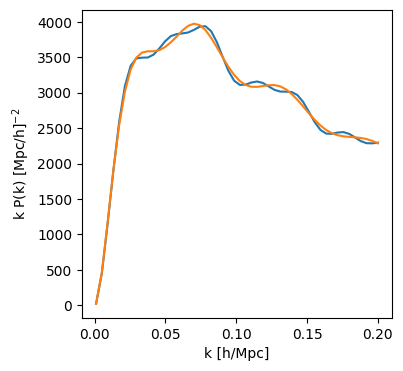

In [7]:
plt.figure(figsize = (4,4))
plt.plot(k, k*ps_linfeature)
plt.plot(k, k*ps_nofeature)
plt.xlabel('k [h/Mpc]')
plt.ylabel(r'k P(k) [Mpc/h]$^{-2}$')

The Gaussian approximation for the covariance matrix of the power spectrum of galaxies is a commonly used approach in cosmology to estimate the uncertainties and correlations in the measured power spectrum. The power spectrum, $P(k)$, describes how the variance of the galaxy density field is distributed over different spatial scales, characterized by the wavenumber $ k $.

In the Gaussian approximation, the covariance matrix $\text{Cov}(P(k_i), P(k_j))$ of the power spectrum $ P(k) $ is given by:

$$
\text{Cov}(P(k_i), P(k_j)) = \frac{2 P(k_i) P(k_j)}{N_{k_i}} \delta_{ij}
$$

where:
- $ P(k_i) $ and $ P(k_j) $ are the power spectrum values at wavenumbers $ k_i $ and $ k_j $, respectively.
- $ N_{k_i} $ is the number of independent modes (or Fourier modes) in the bin centered at $ k_i $.
- $ \delta_{ij} $ is the Kronecker delta, which is 1 if $ i = j $ and 0 otherwise.

This expression assumes that the galaxy density field is a Gaussian random field, which is a reasonable approximation on large scales where the density fluctuations are small. The factor of 2 arises because the power spectrum is a second-order statistic, and the Gaussian approximation assumes that the modes are uncorrelated.

To compute $ N_{k_i} $, you can use:

$$
N_{k_i} = V \frac{k_i^2 \Delta k}{2\pi^2}
$$

where:
- $ V $ is the survey volume.
- $ \Delta k $ is the width of the bin in $ k $-space.

This approximation is useful for estimating the errors on the power spectrum measurements and for constructing likelihood functions for cosmological parameter estimation. However, it is important to note that on smaller scales, where non-linear effects become significant, the Gaussian approximation may break down, and more sophisticated methods may be required to accurately model the covariance matrix.


In [8]:
def gaussian_covariance_matrix(k, Pk, V, delta_k, nbar):
    """
    Compute the Gaussian approximation for the covariance matrix of the power spectrum of galaxies.

    Parameters:
    k (array): Array of wavenumbers.
    Pk (array): Array of power spectrum values corresponding to the wavenumbers.
    V (float): Survey volume.
    delta_k (float): Width of the bin in k-space.

    Returns:
    cov_matrix (2D array): Covariance matrix of the power spectrum.
    """
    # Number of wavenumbers
    N = len(k)
    
    # Initialize the covariance matrix
    cov_matrix = np.zeros((N, N))
    
    # Compute the number of independent modes for each k
    Nk = V * (k**2) * delta_k / (2 * np.pi**2)
    np.fill_diagonal(cov_matrix,2 * Pk**2 / Nk + 1/nbar)
    return cov_matrix

In [9]:
L = 1e3 #Mpc/h
V = (L)**3 #[Mpc/h]^3
delta_k = k[1]-k[0]
nbar = 2e-4
cov = gaussian_covariance_matrix(k,ps_nofeature,V,delta_k,nbar)

Text(0, 0.5, 'k P(k) [Mpc/h]$^{-2}$')

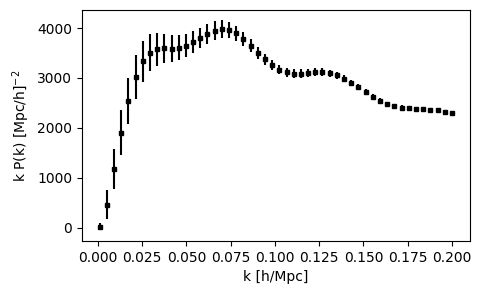

In [10]:
plt.figure(figsize = (5,3))
plt.errorbar(k, k*ps_nofeature, yerr = np.diag(cov)**0.5*k, marker = "s", ls = "", markersize = 3, color = 'black')
plt.xlabel('k [h/Mpc]')
plt.ylabel(r'k P(k) [Mpc/h]$^{-2}$')

Finally, we use the covariance matrix to generate a dataset with errors (ie having some shifts around the smooth line):

In [11]:
noise = np.random.multivariate_normal(mean=np.zeros(len(k)), cov=cov)
DATA = ps_linfeature + noise

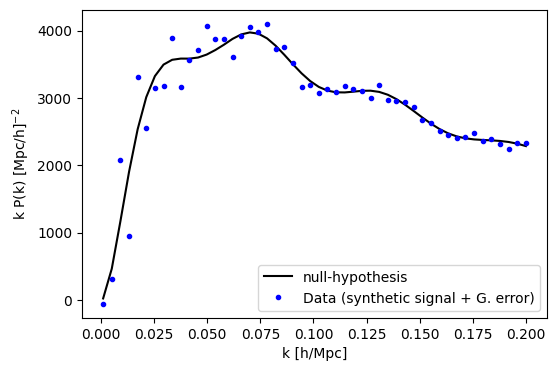

In [12]:
plt.figure(figsize = (6,4))
plt.plot(k, k*ps_nofeature,markersize = 3, color = 'black', label = 'null-hypothesis')
plt.plot(k, k*DATA,markersize = 3, color = 'b', ls = "", marker = "o", label = 'Data (synthetic signal + G. error)')
plt.xlabel('k [h/Mpc]')
plt.ylabel(r'k P(k) [Mpc/h]$^{-2}$')
plt.legend()

In [13]:
invcov = np.linalg.inv(cov)

In the rest of the notebook I will use $\texttt{DATA},\texttt{invcov}$ as data products.

# Creating the likelihood and posterior

In [14]:
from likelihood import *

In [15]:
#The theory has to be a callable. Give the theory parameters as input
theory = lambda x: ps_model_lin.Evaluate_bare(x)[:len(k)] #only get the NGC part

In [16]:
#Initialise the likelihood
likelihood = likelihoods(theory, DATA, invcov)

In [17]:
#To use a gaussian likelihood
theta = params + [A, omega_lin, phi]
print('Input parameters:', theta)
print('The loglikelihood for this set of parameters is:', likelihood.logGaussian(theta))

Input parameters: [3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0.025, 300, 3.14]
The loglikelihood for this set of parameters is: -22.26277184565815


For this example, I will use a flat prior. It can be loaded using the $\texttt{mcmctoolkit}$ module:

In [18]:
#prior to use and start with one walker
priorname = 'lin_simple'
mcmc = MCMC(1, priorname, priors_dir='/Users/s2223060/Desktop/primordial_features/priors')

#get the number of parameters
ndim = mcmc.ndim

#update the number of walkers to 5 per free parameter
mcmc.set_walkers(5*ndim)

2024-09-19 15:58:34,678 - mcmc_toolkit - INFO - Using lin_simple file
2024-09-19 15:58:34,680 - mcmc_toolkit - INFO - Number of walkers set to 25


In [19]:
#Get the flat prior function
in_prior_range = mcmc.in_prior

In [20]:
mcmc.prior_dictionary

OrderedDict([('BNGC', [1, 10]),
             ('alpha', [0.8, 1.2]),
             ('A_lin', [-0.5, 0.5]),
             ('omega_lin', [100, 400]),
             ('phi', [0, 6.28])])

In [21]:
theta = [2,1,0,150,3]
print(in_prior_range(theta))

theta = [100,1,0,150,3]
print(in_prior_range(theta))

True
False


In [22]:
def logposterior(theta):
    if not in_prior_range(theta):
        return -np.inf
    else:
        return likelihood.logGaussian([theta[0], 0, 0, 0, 0, 0, 0, 0, 0, theta[1], theta[2],theta[3],theta[4]])

In [23]:
theta = [2,1,0,150,3]
print(logposterior(theta))

theta = [100,1,0,150,3]
print(logposterior(theta))

-10147.608693538084
-inf


# Constructing the Likelihood and sampling the posterior

I will assume a flat prior for all parameters:

In [24]:
handle = "PrimFeature_lin_tutorial"

In [25]:
initial_pos = mcmc.create_walkers(mode = "uniform_prior")

2024-09-19 15:58:36,959 - mcmc_toolkit - INFO - Using uniform prior
2024-09-19 15:58:36,961 - mcmc_toolkit - INFO - For param BNGC: Minimum: 1.61 | Maximum: 9.83
2024-09-19 15:58:36,962 - mcmc_toolkit - INFO - For param alpha: Minimum: 0.8 | Maximum: 1.17
2024-09-19 15:58:36,963 - mcmc_toolkit - INFO - For param A_lin: Minimum: -0.44 | Maximum: 0.47
2024-09-19 15:58:36,964 - mcmc_toolkit - INFO - For param omega_lin: Minimum: 101.88 | Maximum: 374.51
2024-09-19 15:58:36,965 - mcmc_toolkit - INFO - For param phi: Minimum: 0.83 | Maximum: 6.21


We will run the chain for 1000 steps

In [30]:
mcmc.run(handle, 500,initial_pos,loglikelihood=logposterior, new = False, plots=True)

  5%|█▉                                        | 23/500 [00:00<00:08, 55.08it/s]2024-09-19 15:59:48,580 - mcmc_toolkit - INFO - Mean acceptance fraction: 0.19134426229508197
2024-09-19 15:59:48,580 - mcmc_toolkit - INFO - Mean autocorrelation time: 81.703794043037
  9%|███▋                                      | 44/500 [00:00<00:07, 60.57it/s]2024-09-19 15:59:48,984 - mcmc_toolkit - INFO - Mean acceptance fraction: 0.19125161290322581
2024-09-19 15:59:48,984 - mcmc_toolkit - INFO - Mean autocorrelation time: 82.86844372109599
 14%|██████                                    | 72/500 [00:01<00:06, 63.41it/s]2024-09-19 15:59:49,389 - mcmc_toolkit - INFO - Mean acceptance fraction: 0.19093333333333334
2024-09-19 15:59:49,389 - mcmc_toolkit - INFO - Mean autocorrelation time: 84.15256480135355
 19%|███████▉                                  | 95/500 [00:01<00:06, 65.96it/s]2024-09-19 15:59:49,766 - mcmc_toolkit - INFO - Mean acceptance fraction: 0.190325
2024-09-19 15:59:49,767 - mcmc_toolkit

Removed no burn in
plotting:  ['BNGC', 'alpha']
plotting:  ['BNGC', 'A_lin']
plotting:  ['BNGC', 'omega_lin']
plotting:  ['BNGC', 'phi']
plotting:  ['alpha', 'A_lin']
plotting:  ['alpha', 'omega_lin']
plotting:  ['alpha', 'phi']
plotting:  ['A_lin', 'omega_lin']
plotting:  ['A_lin', 'phi']
plotting:  ['omega_lin', 'phi']


2024-09-19 16:00:03,562 - mcmc_toolkit - INFO - Corner plot saved to /Users/s2223060/Desktop/primordial_features/nb/figures/PrimFeature_lin_tutorial_Corner.png
2024-09-19 16:00:03,570 - mcmc_toolkit - INFO - Done!
